# Vodafone Age (визначення вікової групи абонента)

In [112]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest


In [113]:
file_path = './vodafone_age_subset.csv'
df = pd.read_csv(file_path, delimiter=',')

In [114]:
df.head()


,CALCULATION_METHOD_ID,calls_count_in_weekdays,calls_duration_in_weekdays,calls_count_out_weekdays,calls_duration_out_weekdays,calls_count_in_weekends,calls_duration_in_weekends,calls_count_out_weekends,calls_duration_out_weekends,DATA_VOLUME_WEEKDAYS,...,applemaps_volume,applemaps_count,msoffice365_volume,msoffice365_count,jabber_volume,jabber_count,telegram_volume,telegram_count,user_hash,target
0,2,10.87,32.025,17.74,40.819,7.00,21.463,11.13,20.427,154.837,...,0.0,0.0,0.09,9.29,0.0000,0.0,0.0,0.0,312ca09052ac6eb49fbd2a546a782df5,4
1,1,0.91,1.346,0.48,0.546,0.25,0.688,0.75,0.708,53.639,...,0.0,0.0,0.00,0.00,0.0033,0.1,0.0,0.0,327733ea2cea082b48707d2700b49327,4
2,2,0.00,0.000,0.00,0.000,0.00,0.000,0.00,0.000,0.000,...,0.0,0.0,0.00,0.00,0.0000,0.0,0.0,0.0,22ede60385359c8c24bc68449ca56763,6
3,2,7.39,30.278,11.00,44.182,5.00,20.008,8.38,32.385,0.000,...,0.0,0.0,0.00,0.00,0.0000,0.0,0.0,0.0,67682b3b1d1319a7cf90ed80eb16b899,5
4,1,0.43,0.996,0.70,1.609,2.25,3.115,0.00,0.000,0.000,...,0.0,0.0,0.00,0.00,0.0000,0.0,0.0,0.0,334e5ceddcc4f11f261322832526ae49,3


In [115]:
df.isnull().sum()

CALCULATION_METHOD_ID          0
calls_count_in_weekdays        0
calls_duration_in_weekdays     0
calls_count_out_weekdays       0
calls_duration_out_weekdays    0
                              ..
jabber_count                   0
telegram_volume                0
telegram_count                 0
user_hash                      0
target                         0
Length: 116, dtype: int64

In [116]:
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print(f"Постійні колонки: {constant_columns}\n")

Постійні колонки: ['SBERBANK']



In [117]:
duplicates = df.duplicated().sum()
print(f"Кількість дубльованих рядків: {duplicates}\n")

Кількість дубльованих рядків: 0



In [118]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"Категоріальні дані: {categorical_columns}")

Категоріальні дані: ['Oblast_post_HOME', 'Raion_post_HOME', 'City_post_HOME', 'Oblast_post_WORK', 'Raion_post_WORK', 'City_post_WORK', 'device_brand', 'device_model', 'software_os_vendor', 'software_os_name', 'software_os_version', 'device_type_rus', 'SCORING', 'user_hash']


In [119]:
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
print(f"Числові дані: {numerical_columns}")

Числові дані: ['CALCULATION_METHOD_ID', 'calls_count_in_weekdays', 'calls_duration_in_weekdays', 'calls_count_out_weekdays', 'calls_duration_out_weekdays', 'calls_count_in_weekends', 'calls_duration_in_weekends', 'calls_count_out_weekends', 'calls_duration_out_weekends', 'DATA_VOLUME_WEEKDAYS', 'DATA_VOLUME_WEEKENDS', 'LAT_HOME', 'LON_HOME', 'lat_quad_home', 'lon_quad_home', 'LAT_WORK', 'LON_WORK', 'lat_quad_work', 'lon_quad_work', 'sim_count', 'AVG_ARPU', 'ROUM', 'phone_value', 'car', 'gender', 'lifetime', 'how_long_same_model', 'ecommerce_score', 'PRIVAT', 'OSCHADBANK', 'ALFABANK', 'UKRSOTBANK', 'OTP', 'UKRGASBANK', 'RAIFFEISEN', 'PIVDENNYI', 'IDEABANK', 'SBERBANK', 'MONOBANK', 'PRAVEXBANK', 'UKRSIB', 'banks_sms_count', 'SHELL', 'OKKO', 'SUNOIL', 'KLO', 'BRSM', 'AMIC', 'TNK', 'UPG', 'gas_stations_sms', 'fb_volume', 'fb_count', 'instagram_volume', 'intagram_count', 'viber_volume', 'viber_count', 'youtube_volume', 'youtube_count', 'google_volume', 'google_count', 'gmail_volume', 'gmail

In [120]:
identification_columns = [col for col in df.columns if 'id' in col.lower() or 'hash' in col.lower()]
print(f"Ідентифікаційні дані\n: {identification_columns}")

Ідентифікаційні дані
: ['CALCULATION_METHOD_ID', 'IDEABANK', 'user_hash']


In [121]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Columns: 116 entries, CALCULATION_METHOD_ID to target
dtypes: float64(97), int64(5), object(14)
memory usage: 18.6+ MB
None


In [122]:
print(df.describe().T)

                               count       mean        std  min    25%  \
CALCULATION_METHOD_ID        21000.0   1.504190   0.499994  1.0  1.000   
calls_count_in_weekdays      21000.0   5.024132   9.872541  0.0  1.220   
calls_duration_in_weekdays   21000.0  11.166896  13.998677  0.0  2.411   
calls_count_out_weekdays     21000.0   5.250357  11.382722  0.0  1.000   
calls_duration_out_weekdays  21000.0  12.010912  15.876250  0.0  2.021   
...                              ...        ...        ...  ...    ...   
jabber_volume                21000.0   0.001798   0.068234  0.0  0.000   
jabber_count                 21000.0   0.050738   3.514625  0.0  0.000   
telegram_volume              21000.0   0.003654   0.140272  0.0  0.000   
telegram_count               21000.0   0.126115   3.443548  0.0  0.000   
target                       21000.0   4.226000   1.222038  1.0  3.000   

                                50%       75%       max  
CALCULATION_METHOD_ID        2.0000   2.00000    2.00

In [123]:
df=df.drop(constant_columns, axis=1)
print(f"Оновлена кількість колонок: {df.shape[1]}")


Оновлена кількість колонок: 115


In [124]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Columns: 115 entries, CALCULATION_METHOD_ID to target
dtypes: float64(96), int64(5), object(14)
memory usage: 18.4+ MB


,count,mean,std,min,25%,50%,75%,max
CALCULATION_METHOD_ID,21000.0,1.504190,0.499994,1.0,1.000,2.0000,2.00000,2.0000
calls_count_in_weekdays,21000.0,5.024132,9.872541,0.0,1.220,3.3500,6.70000,742.6100
calls_duration_in_weekdays,21000.0,11.166896,13.998677,0.0,2.411,7.4855,15.79525,818.3590
calls_count_out_weekdays,21000.0,5.250357,11.382722,0.0,1.000,3.2600,6.87000,680.0900
calls_duration_out_weekdays,21000.0,12.010912,15.876250,0.0,2.021,7.4220,16.77200,770.0130
...,...,...,...,...,...,...,...,...
jabber_volume,21000.0,0.001798,0.068234,0.0,0.000,0.0000,0.00000,6.0645
jabber_count,21000.0,0.050738,3.514625,0.0,0.000,0.0000,0.00000,498.5500
telegram_volume,21000.0,0.003654,0.140272,0.0,0.000,0.0000,0.00000,14.5498
telegram_count,21000.0,0.126115,3.443548,0.0,0.000,0.0000,0.00000,308.6100


In [125]:
df = df[['target','CALCULATION_METHOD_ID','calls_count_in_weekdays','calls_duration_in_weekdays','calls_count_out_weekdays','calls_duration_out_weekdays','calls_count_in_weekends','calls_duration_in_weekends','calls_count_out_weekends','calls_duration_out_weekends', 'DATA_VOLUME_WEEKDAYS', 'DATA_VOLUME_WEEKENDS']]
df


,target,CALCULATION_METHOD_ID,calls_count_in_weekdays,calls_duration_in_weekdays,calls_count_out_weekdays,calls_duration_out_weekdays,calls_count_in_weekends,calls_duration_in_weekends,calls_count_out_weekends,calls_duration_out_weekends,DATA_VOLUME_WEEKDAYS,DATA_VOLUME_WEEKENDS
0,4,2,10.87,32.025,17.74,40.819,7.00,21.463,11.13,20.427,154.837,181.143
1,4,1,0.91,1.346,0.48,0.546,0.25,0.688,0.75,0.708,53.639,49.009
2,6,2,0.00,0.000,0.00,0.000,0.00,0.000,0.00,0.000,0.000,0.000
3,5,2,7.39,30.278,11.00,44.182,5.00,20.008,8.38,32.385,0.000,0.000
4,3,1,0.43,0.996,0.70,1.609,2.25,3.115,0.00,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
20995,5,2,0.00,0.000,0.00,0.000,0.00,0.000,0.00,0.000,0.000,0.000
20996,4,1,4.43,5.143,3.48,5.522,6.75,10.085,3.25,5.088,44.858,22.394
20997,3,1,0.22,0.185,1.00,6.418,0.00,0.000,0.63,6.096,120.961,78.257
20998,4,2,5.04,14.699,6.39,20.441,2.25,5.485,3.63,27.802,27.127,67.017


In [126]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,21000.0,4.226000,1.222038,1.0,3.0000,4.0000,5.00000,6.000
CALCULATION_METHOD_ID,21000.0,1.504190,0.499994,1.0,1.0000,2.0000,2.00000,2.000
calls_count_in_weekdays,21000.0,5.024132,9.872541,0.0,1.2200,3.3500,6.70000,742.610
calls_duration_in_weekdays,21000.0,11.166896,13.998677,0.0,2.4110,7.4855,15.79525,818.359
calls_count_out_weekdays,21000.0,5.250357,11.382722,0.0,1.0000,3.2600,6.87000,680.090
calls_duration_out_weekdays,21000.0,12.010912,15.876250,0.0,2.0210,7.4220,16.77200,770.013
calls_count_in_weekends,21000.0,3.154089,10.215863,0.0,0.6300,2.0000,4.13000,938.630
calls_duration_in_weekends,21000.0,7.902830,12.926433,0.0,1.0745,4.3400,10.45600,785.744
calls_count_out_weekends,21000.0,3.367175,10.807576,0.0,0.5000,2.0000,4.38000,734.750
calls_duration_out_weekends,21000.0,8.613460,13.923745,0.0,0.8440,4.4470,11.35925,720.288


<Axes: xlabel='target'>

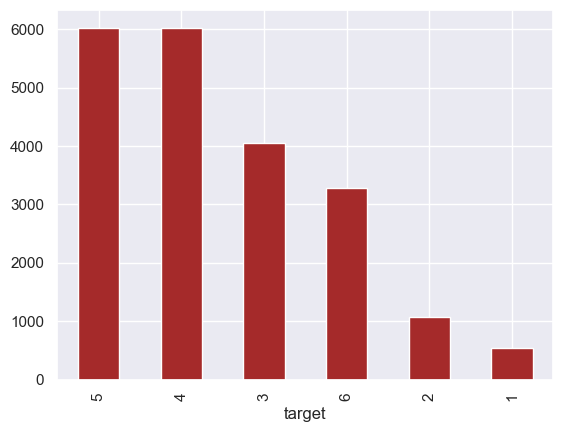

In [155]:
sns.set(style='darkgrid') 
df['target'].value_counts().plot(kind='bar', color = 'brown')


Основна кількість абонентів відноситься до вікової групи 4 і 5.
Класи незбалансовані

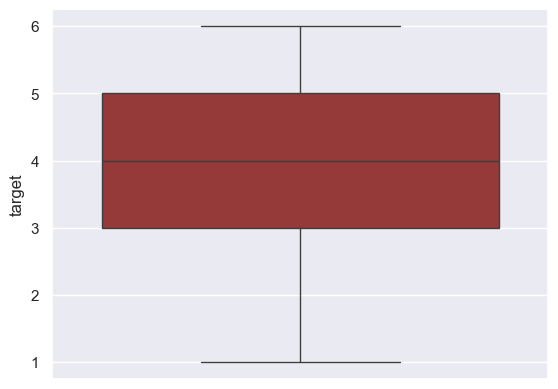

In [154]:
sns.set(style='darkgrid') 
sns.boxplot(df['target'], color='brown')
plt.show()

Висновок: розподіл нормальний

---


Розраховуємо коефіцієнт спірмана, щоб визначити силу та напрямок зв’язку між числовими ознаками і цільовою змінною target для оцінки їх значущості в задачі прогнозування.

In [129]:
from scipy.stats import spearmanr

numeric_columns = ['calls_count_in_weekdays', 'calls_duration_in_weekdays', 
                   'calls_count_out_weekdays', 'calls_duration_out_weekdays', 
                   'calls_count_in_weekends', 'calls_duration_in_weekends', 
                   'calls_count_out_weekends', 'calls_duration_out_weekends',
                   'DATA_VOLUME_WEEKDAYS', 'DATA_VOLUME_WEEKENDS']
for column in numeric_columns:
    r = spearmanr(df[column], df['target'])

    print(f"Spearmanr correlation for {column}: {r[0]}, p-value = {r[1]}")


Spearmanr correlation for calls_count_in_weekdays: -0.12322800501595842, p-value = 7.562628727075586e-72
Spearmanr correlation for calls_duration_in_weekdays: -0.02779565884543863, p-value = 5.613095803323471e-05
Spearmanr correlation for calls_count_out_weekdays: -0.10102643948260312, p-value = 9.075842724861537e-49
Spearmanr correlation for calls_duration_out_weekdays: -0.04272790726220561, p-value = 5.853638879331425e-10
Spearmanr correlation for calls_count_in_weekends: -0.11933367762243, p-value = 1.8363950049064803e-67
Spearmanr correlation for calls_duration_in_weekends: -0.0038740476195031548, p-value = 0.5745442918922734
Spearmanr correlation for calls_count_out_weekends: -0.09343411998372173, p-value = 6.133954267627265e-42
Spearmanr correlation for calls_duration_out_weekends: -0.014405608325602916, p-value = 0.03683799289433937
Spearmanr correlation for DATA_VOLUME_WEEKDAYS: -0.37548698818208215, p-value = 0.0
Spearmanr correlation for DATA_VOLUME_WEEKENDS: -0.3579137960328

Коефіцієнт кореляції Спірмена (r):

  - Більшість змінних мають слабкий зв'язок із цільовою змінною target (значення r ближчі до 0, ніж до ±1).
  - Дві змінні, DATA_VOLUME_WEEKDAYS і DATA_VOLUME_WEEKENDS, показують помітнішу кореляцію з target (r ≈ -0.36…-0.38), що може свідчити про їхню значущість для прогнозування.

p-value:

  - Для більшості змінних значення p-value дуже мале (< 0.05), що вказує на статистичну значущість кореляції.
  - Виняток — змінна calls_duration_in_weekends, де p-value = 0.5745, що свідчить про відсутність статистично значущої кореляції.

In [130]:
X = df.drop('target', axis = 1 ) 
y = df['target'] 

scaler = StandardScaler()
scaler.fit(X)
X_st = scaler.transform(X)#  transform() для масштабування значень кажлого стовпця DF
print(X_st[:5])


[[ 0.99165388  0.59214822  1.49004082  1.09727188  1.81458297  0.37647361
   1.0490514   0.71829333  0.8484658   0.72212374  0.92218809]
 [-1.00841637 -0.41673466 -0.70157557 -0.41909755 -0.72215952 -0.28427922
  -0.55815878 -0.24216688 -0.5677817   0.01902284  0.01168847]
 [ 0.99165388 -0.50891171 -0.7977298  -0.46126773 -0.75655133 -0.30875155
  -0.61138432 -0.3115643  -0.6186313  -0.35364884 -0.32601929]
 [ 0.99165388  0.23964697  1.36524034  0.50513225  2.02641385  0.18069499
   0.93648866  0.46383615  1.7073069  -0.35364884 -0.32601929]
 [-1.00841637 -0.46535552 -0.72657852 -0.39976955 -0.65520257 -0.08850061
  -0.3703995  -0.3115643  -0.6186313  -0.35364884 -0.32601929]]


In [131]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_st, y, test_size=0.20, random_state=19)

Розбиваємо набір даних на навчавльну та валідаційну вибірки. В співвідношені 80 на 20.

---

# KNN


Вказавши к-ть найближчих сусідів (7), ми викликаємо метод fit для навчання моделі на навчальних даних. Викликаємо predict для передбачення класів для перевірочних даних x_valid.

In [138]:
from sklearn.neighbors import KNeighborsClassifier 

knn = KNeighborsClassifier(n_neighbors=7) 
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)
print(y_pred)


[3 5 4 ... 3 5 5]


---

На цьому етапі проводиться оцінка якості класифікаційної моделі за допомогою метрики точності (accuracy).

y_valid — це вектор правильних (істинних) міток класів для валідаційної вибірки. Він відображає, до якого класу реально належить кожен об'єкт у перевірочних даних.
y_pred — це вектор передбачених міток класів, який був згенерований моделлю для тих самих об'єктів.

In [139]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid, y_pred)
print(accuracy)


0.3319047619047619


На основі вираних даних ми маємо значення accuracy = 0.3319 свідчить про те, що модель правильно класифікувала лише 33.19% прикладів із валідаційної вибірки. Це дуже низький показник для більшості завдань класифікації.
Причина цього в тому, що вибрані дані з високою кардинальністю і без попередньої обробки маємо певні труднощі в моделюванні.

---

Цей крок виконує оцінку якості моделі K-Nearest Neighbors (KNN) за допомогою методу крос-валідації:

Переваги методу:
-  Замість простої точності (accuracy), яка може бути упередженою до частіших класів, використовується зважена F1-метрика:
  - F1-метрика об'єднує точність (precision) і повноту (recall), що робить її більш придатною для оцінки моделей у випадку дисбалансу.
  - Параметр average='weighted' гарантує, що метрика буде пропорційно враховувати кількість кожного класу.
- Крос-валідація
  - Використання KFold розбиває дані на кілька фолдів, що:
    - Забезпечує стійкішу оцінку моделі.
    - Зменшує ризик переобучення (overfitting) або недообучення (underfitting).
    - Це дозволяє отримати середнє значення F1-метрики, яке краще відображає продуктивність моделі на різних частинах даних.

In [144]:
from sklearn.metrics import make_scorer, f1_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=7)

# Використовуємо F1-метрику зважену (weighted) для урахування дисбалансу класів
f1_scorer = make_scorer(f1_score, average='weighted')
scores = cross_val_score(estimator=knn, X=X_st, y=y, cv=kf, scoring=f1_scorer)

print(f"Масив значень F1-метрики: {scores}")
print(f"Середня F1-метрика на крос-валідації: {scores.mean()}")


Масив значень F1-метрики: [0.31794634 0.31931885 0.31871329 0.32325189 0.31770671]
Середня F1-метрика на крос-валідації: 0.31938741401176884


- Масив значень метрики: Показує, як змінюється точність моделі на кожному фолді. Велика варіативність може свідчити про нестабільність моделі або нерівномірність даних. Різниця між значеннями незначна, що свідчить про відносну стабільність моделі на різних частинах даних.

- Середня метрика на крос-валідації: Узагальнює результат і допомагає оцінити, наскільки добре модель працює на нових даних. В середньому модель правильно класифікує 31.93% прикладів.

---

Пошук оптимального значення гіперпараметра для моделі KNN

In [145]:
knn_params = {'n_neighbors': np.arange(1, 51)}

knn = KNeighborsClassifier()
f1_scorer = make_scorer(f1_score, average='weighted')

knn_grid = GridSearchCV(knn, knn_params, scoring=f1_scorer, cv=5)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=7),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='accuracy')

In [146]:
knn_grid.best_estimator_



KNeighborsClassifier(n_neighbors=48)

In [147]:
knn_grid.best_score_

0.3553571428571428

Найкращу можливу для нашої вибірки якість ми отримали при кількості сусідів = 48. 

---


Візуалзація валідаційної кривої 

<Figure size 1000x800 with 0 Axes>

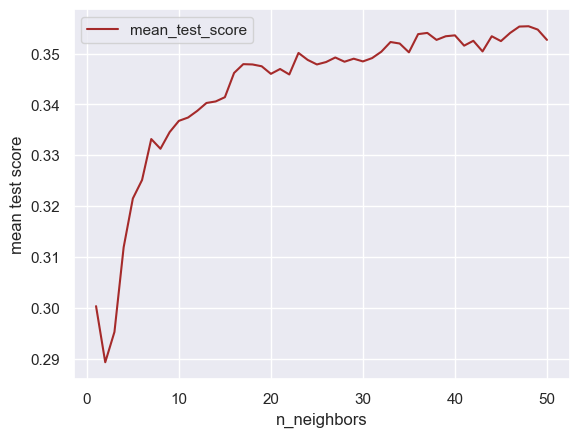

In [153]:
import matplotlib.pyplot as plt
results_df = pd.DataFrame(knn_grid.cv_results_)
grid_results = results_df[['param_n_neighbors', 'mean_test_score']]

sns.set(style='darkgrid') 
plt.figure(figsize=(10, 8))
grid_results.plot(x='param_n_neighbors', y='mean_test_score', color='brown')
plt.xlabel('n_neighbors')
plt.ylabel('mean test score')
plt.show()


- На малих значеннях n_neighbors (до 10) видно стрімке зростання середнього значення тестової метрики. Це вказує на те, що при збільшенні кількості сусідів модель стає менш чутливою до шуму даних і краще узагальнює результати.

- Починаючи приблизно з n_neighbors = 15, точність стабілізується, досягаючи значень близько 0.35. Це свідчить про те, що додавання сусідів після цього моменту незначно впливає на продуктивність моделі.

- На дуже високих значеннях n_neighbors (близько 50) точність починає незначно знижуватися. Це може бути викликано тим, що модель стає занадто узагальненою, оскільки враховує надто багато сусідів.

---

Результати в вигляді таблиці:

In [149]:
pd.DataFrame(knn_grid.cv_results_).T


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
mean_fit_time,0.042687,0.037202,0.032475,0.031781,0.031604,0.041448,0.037569,0.03141,0.031751,0.122928,...,0.036892,0.056937,0.040654,0.033622,0.037667,0.031193,0.031163,0.033971,0.031619,0.032505
std_fit_time,0.013913,0.00425,0.001866,0.000808,0.001242,0.014088,0.00934,0.000441,0.000492,0.001885,...,0.009056,0.016817,0.018005,0.003065,0.012796,0.000267,0.000634,0.005657,0.000758,0.002048
mean_score_time,0.252427,0.288096,0.284533,0.305739,0.327292,0.338434,0.372043,0.327839,0.345774,1.341859,...,0.500249,0.751305,0.473906,0.55269,0.476949,0.440842,0.453993,0.444829,0.456573,0.44565
std_score_time,0.037759,0.022719,0.014518,0.032527,0.04655,0.034131,0.065865,0.017619,0.042284,0.076503,...,0.075089,0.197287,0.088686,0.099127,0.05319,0.018822,0.019356,0.025171,0.034553,0.021365
param_n_neighbors,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
params,{'n_neighbors': 1},{'n_neighbors': 2},{'n_neighbors': 3},{'n_neighbors': 4},{'n_neighbors': 5},{'n_neighbors': 6},{'n_neighbors': 7},{'n_neighbors': 8},{'n_neighbors': 9},{'n_neighbors': 10},...,{'n_neighbors': 41},{'n_neighbors': 42},{'n_neighbors': 43},{'n_neighbors': 44},{'n_neighbors': 45},{'n_neighbors': 46},{'n_neighbors': 47},{'n_neighbors': 48},{'n_neighbors': 49},{'n_neighbors': 50}
split0_test_score,0.296131,0.291071,0.296726,0.315179,0.325893,0.330655,0.341964,0.33244,0.341369,0.338095,...,0.360417,0.364583,0.360417,0.367857,0.368155,0.36756,0.36994,0.373512,0.37381,0.372917
split1_test_score,0.294345,0.290179,0.295833,0.305952,0.319048,0.317262,0.328571,0.327679,0.329167,0.330357,...,0.341667,0.346726,0.340179,0.34375,0.341667,0.345536,0.34881,0.347024,0.346429,0.340179
split2_test_score,0.300298,0.28125,0.297619,0.314881,0.319048,0.32381,0.328869,0.329464,0.334226,0.340774,...,0.3625,0.359226,0.358631,0.361012,0.360714,0.358631,0.360417,0.356548,0.352976,0.353274
split3_test_score,0.307738,0.292857,0.299107,0.315774,0.32381,0.328274,0.332143,0.334821,0.33125,0.33631,...,0.339583,0.341964,0.342857,0.342262,0.340179,0.341071,0.3375,0.339881,0.343452,0.33869


---

Передбачення на тестовій вибірці для оптимаьлного числа кількості сусідів

In [150]:
y_pred = knn_grid.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.34904761904761905

In [151]:
best_knn = KNeighborsClassifier(n_neighbors=48)

y_pred = best_knn.fit(X_train, y_train).predict(X_valid)

f1 = f1_score(y_valid, y_pred, average='weighted')
print(f"F1-метрика на валідаційних даних: {f1}")


F1-метрика на валідаційних даних: 0.3368368960069534


# Лінійна регресія

In [152]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score 

lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_valid)

mse = mean_squared_error(y_valid, y_pred)# середньоквадратична похибка
mae = mean_absolute_error(y_valid, y_pred)# середня абсолютна похибка
medae = median_absolute_error(y_valid, y_pred)# медіанна абсолютна похибка
r2 = r2_score(y_valid, y_pred)# коефіцієнт детермінації

print('MSE:', mse)
print('MAE:', mae)
print('MedAE:', medae)
print('R2:', r2)


MSE: 1.2556958930212918
MAE: 0.8951014999574965
MedAE: 0.7704928223240235
R2: 0.18926513630921715


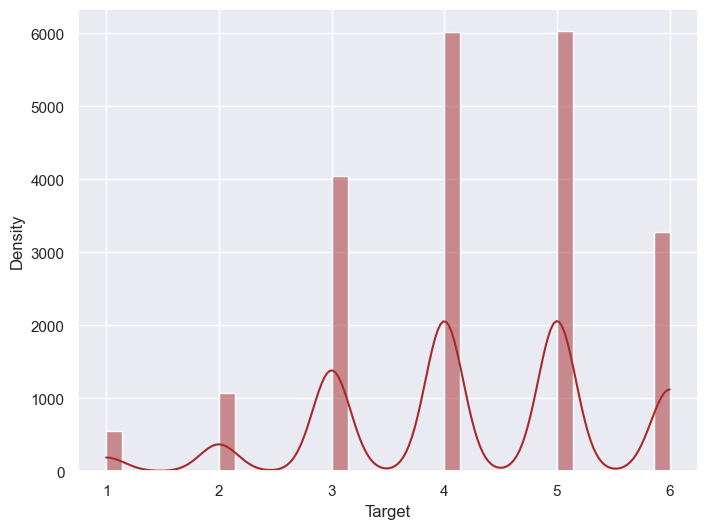

In [156]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set(style='darkgrid') 
plt.figure(figsize=(8, 6))

sns.histplot(data=df, x='target', kde=True, color='brown')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()


Дані явно розподілені категорично, з чітко вираженими стовпцями для значень 1, 2, 3, 4, 5 і 6.
Найвища частота спостерігається для категорій 4 і 5.

Лінія густини демонструє циклічну поведінку з піками, які відповідають високим частотам (4, 5).
Лінія густини згладжує дискретні категорії, що дає уявлення про розподіл у безперервному вигляді.

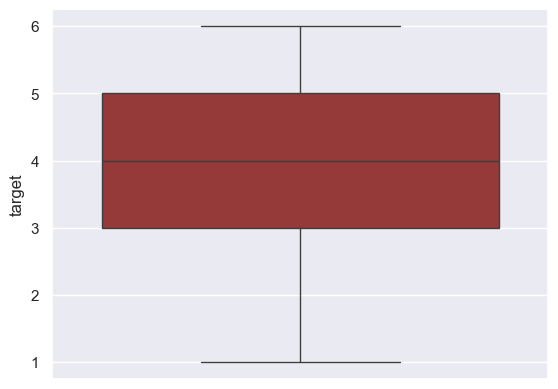

In [157]:
sns.set(style='darkgrid') 
sns.boxplot(df['target'], color='brown')
plt.show()

In [158]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_valid)

print('MSE:', mean_squared_error(y_valid, y_pred))
print('MAE:', mean_absolute_error(y_valid, y_pred))
print('MedAE:', median_absolute_error(y_valid, y_pred))
print('R2:', r2_score(y_valid, y_pred))


MSE: 1.2556964410972125
MAE: 0.8951034169215575
MedAE: 0.7706317863374026
R2: 0.1892647824462642


In [159]:
from sklearn.model_selection import GridSearchCV

alpha_grid = {'alpha': np.logspace(-4, 4, 20)} 
ridge_grid = GridSearchCV(ridge, alpha_grid, cv=5, scoring='neg_mean_squared_error') 
ridge_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             scoring='neg_mean_squared_error')

In [160]:
print('Best alpha:', ridge_grid.best_params_)
print('Best score:', ridge_grid.best_score_)


Best alpha: {'alpha': 29.763514416313132}
Best score: -1.2068746407689275


Перенавчання немає. Проблема скоріше в недонавченні (модель не здатна повністю пояснити залежність між змінними).

# Lasso

In [161]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_valid)

print('MSE:', mean_squared_error(y_valid, y_pred))
print('MAE:', mean_absolute_error(y_valid, y_pred))
print('MedAE:', median_absolute_error(y_valid, y_pred)) 
print('R2:', r2_score(y_valid, y_pred)) 


MSE: 1.5519740114795921
MAE: 1.014407738095238
MedAE: 0.7627976190476193
R2: -0.0020256063919525946


In [162]:
eps = 1e-6 
lasso_coef = lasso.coef_
print('Нульові коефіцієнти:', sum(np.abs(lasso_coef) < eps)) 
print('Всього коефіцієнтів:', lasso_coef.shape[0])


Нульові коефіцієнти: 11
Всього коефіцієнтів: 11


Всі коефіцієнти стали нульовими, тому налаштовуємо alpha.

In [173]:
alpha_grid = {'alpha': np.logspace(-3, 3, 10)} 
lasso_grid = GridSearchCV(lasso, alpha_grid, cv=5, scoring='neg_mean_squared_error') 
lasso_grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [174]:
print('Best alpha:', lasso_grid.best_params_)
print('Best score:', lasso_grid.best_score_)

Best alpha: {'alpha': 0.001}
Best score: -1.2069405512571805


In [175]:
lasso_best = lasso_grid.best_estimator_
y_pred = lasso_best.predict(X_valid)
print('R2:', r2_score(y_valid, y_pred))

R2: 0.18908440684490968


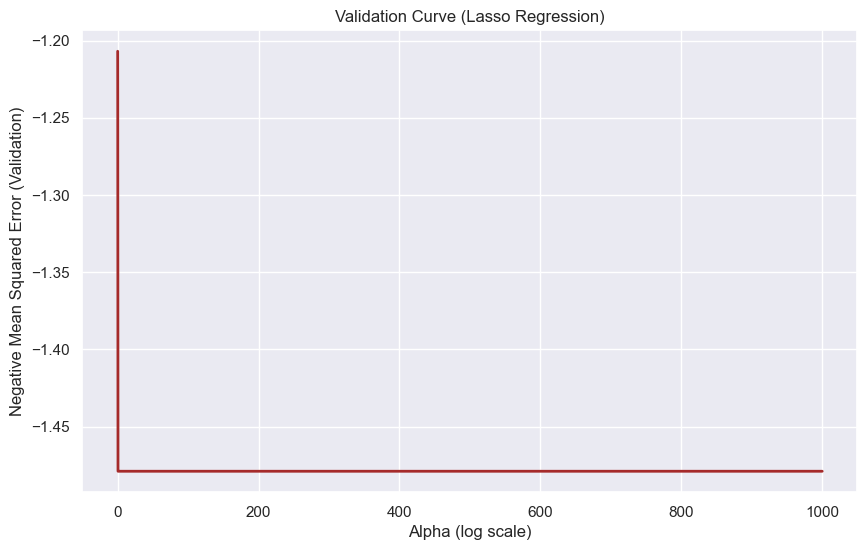

In [177]:
plt.plot(results_df['param_alpha'], results_df['mean_test_score'], color='brown', linewidth=2)
plt.xlabel('Alpha (log scale)')
plt.ylabel('Negative Mean Squared Error (Validation)')
plt.title('Validation Curve (Lasso Regression)')
plt.rcParams['figure.figsize'] = [10, 6]
plt.grid(True)
plt.show()


Надто маленькі чи надто великі значення alpha можуть призводити до недо- чи перенавчання. Знайдений параметр alpha, є оптимальним для цього набору даних.

In [178]:
eps = 1e-6
lasso_coef = lasso_best.coef_
print('Нульових коефіцієнтів:', sum(np.abs(lasso_coef) < eps))
print('Всього коефіцієнтів:', lasso_coef.shape[0])


Нульових коефіцієнтів: 1
Всього коефіцієнтів: 11


## R2_score

Ridge для r2

In [179]:
alpha_grid = {'alpha': np.logspace(-4, 4, 20)} 
ridge_grid = GridSearchCV(ridge, alpha_grid, cv=5, scoring='r2') 
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             scoring='r2')

In [180]:
print('Best alpha:', ridge_grid.best_params_)
print('Best score:', ridge_grid.best_score_)

Best alpha: {'alpha': 29.763514416313132}
Best score: 0.18372599690877198


In [184]:
ridge_best = ridge_grid.best_estimator_ 
y_pred = ridge_best.predict(X_valid)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('MAE:', mean_absolute_error(y_valid, y_pred)) 
print('MedAE:', median_absolute_error(y_valid, y_pred))  
print('R2:', r2_score(y_valid, y_pred))


MSE: 1.255728029551654
MAE: 0.8951560082981124
MedAE: 0.7694752942564662
R2: 0.1892443874912052


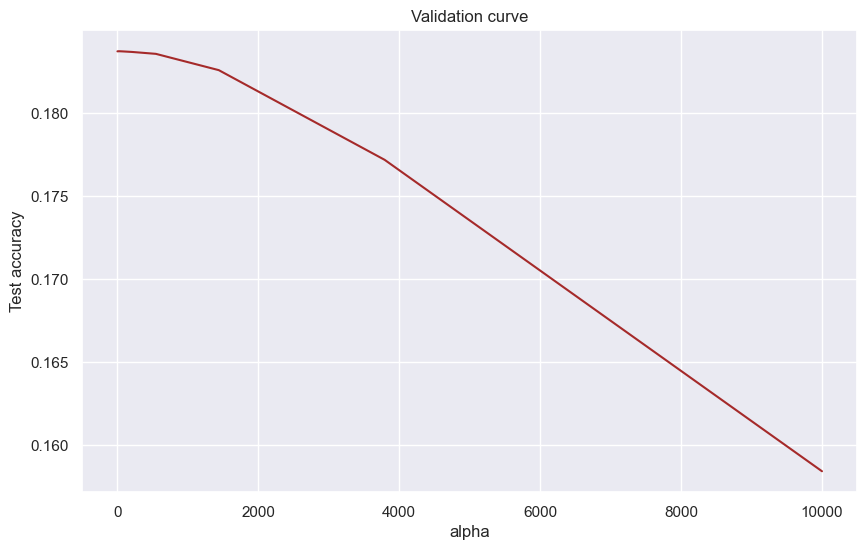

In [185]:
results_df = pd.DataFrame(ridge_grid.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(results_df['param_alpha'], results_df['mean_test_score'], color='brown')


plt.xlabel('alpha')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()


- Графік показує, що при значеннях α, близьких до нуля, модель має максимальну тестову точність (r2). Це свідчить про те, що слабка регуляризація дозволяє моделі краще підлаштовуватися під дані, зберігаючи достатню гнучкість.

- При збільшенні α точність поступово знижується. Це пояснюється тим, що регуляризація стає занадто сильною, обмежуючи ваги моделі і зменшуючи її здатність враховувати важливі особливості даних. Як результат, модель починає недонавчатися (underfitting).

- Графік демонструє монотонне зниження тестової точності зі збільшенням α. Це типовий випадок, коли надмірна регуляризація пригнічує здатність моделі адекватно відображати залежності в даних.

- Найкраще значення α, яке було знайдено під час перехресної перевірки, становить α≈29.76. Це компроміс між запобіганням перенавчанню (занадто малі значення α) і надмірним недонавчанням (великі значення α).

Висновок:

- Значення оптимального α свідчить про те, що модель потребує регуляризації для контролю складності та запобігання перенавчанню. Проте надмірна регуляризація (велике α) негативно впливає на точність.
- Невисокі значення R2 (близько 0.18) вказують на обмежену здатність моделі пояснювати варіацію цільової змінної. Можливо, необхідно додатково оптимізувати гіперпараметри або розглянути інші моделі.

Lasso для r2


In [186]:
alpha_grid = {'alpha': np.logspace(-3, 3, 10)} 
lasso_grid = GridSearchCV(lasso, alpha_grid, cv=5, scoring='r2') 
lasso_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='r2')

In [187]:
print('Best alpha:', lasso_grid.best_params_) 
print('Best score:', lasso_grid.best_score_)

Best alpha: {'alpha': 0.001}
Best score: 0.18368121957070532


In [189]:
lasso_best = lasso_grid.best_estimator_
y_pred = lasso_best.predict(X_valid)
print('MSE:', mean_squared_error(y_valid, y_pred))
print('MAE:', mean_absolute_error(y_valid, y_pred)) 
print('MedAE:', median_absolute_error(y_valid, y_pred)) 
print('R2:', r2_score(y_valid, y_pred))


MSE: 1.2559758134444075
MAE: 0.8955923106079261
MedAE: 0.7714580476523112
R2: 0.18908440684490968


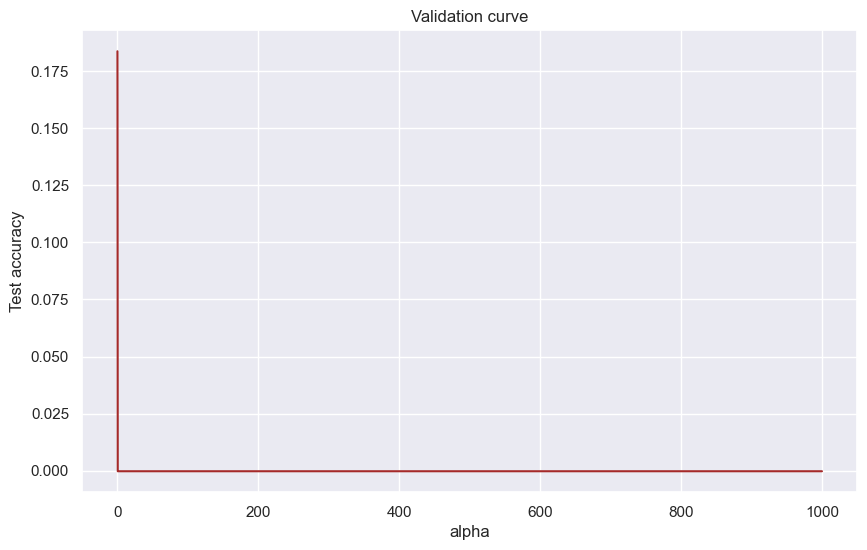

In [190]:
results_df = pd.DataFrame(lasso_grid.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(results_df['param_alpha'], results_df['mean_test_score'], color='brown')


plt.xlabel('alpha')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

**Результати**
2.1. Оптимальне значення параметра регуляризації:
- **Best alpha**: \( \alpha = 0.001 \)
2.2. Найкраще середнє значення коефіцієнта детермінації \( R^2 \) на крос-валідації:
- **Best score**: \( R^2 = 0.184 \)

2.3. Оцінка моделі на валідаційній вибірці:
- **Середньоквадратична похибка (MSE)**: \( 1.256 \)
- **Середня абсолютна похибка (MAE)**: \( 0.896 \)
- **Медіанна абсолютна похибка (MedAE)**: \( 0.771 \)
- **Коефіцієнт детермінації (R2)**: \( R^2 = 0.189 \)


**Аналіз графіка "Validation curve"**
Графік залежності тестової точності від значення \( \alpha \) демонструє такі ключові особливості:

1. **Максимальна точність при найменшому \( \alpha \):**
   - Модель демонструє найкращий результат (\( R^2 = 0.184 \)) при \( \alpha = 0.001 \). Це свідчить про мінімальну регуляризацію, коли Lasso ще не накладає суттєвих обмежень на ваги моделі.

2. **Різке зниження точності при більших \( \alpha \):**
   - Починаючи з \( \alpha > 0.001 \), тестова точність різко падає і стає близькою до нуля. Це вказує на те, що надмірна регуляризація занадто сильно зменшує ваги ознак (деякі стають рівними нулю), що призводить до недонавчання моделі (underfitting).

3. **Незначна чутливість до більших \( \alpha \):**
   - На графіку видно, що для значень \( \alpha \geq 1 \) тестова точність практично не змінюється і залишається на дуже низькому рівні.


**Інтерпретація результатів**
1. **Оптимальне значення \( \alpha = 0.001 \):**
   - Регуляризація в цьому випадку дозволяє трохи скоригувати модель, щоб уникнути перенавчання, але при цьому не зменшує суттєво її здатність відображати залежності в даних.

2. **Недостатня ефективність моделі (низький \( R^2 \)):**
   - Значення \( R^2 \approx 0.19 \) свідчить, що модель пояснює лише близько 19% варіації цільової змінної. Це може вказувати на обмеженість використаних ознак або слабку здатність моделі захоплювати залежності.

3. **Стабільність на великих \( \alpha \):**
   - Сильна регуляризація призводить до обнулення більшості ваг, через що модель перетворюється на майже константну. Це пояснює низькі результати при великих значеннях \( \alpha \).

**Рекомендації**
1. **Розширити набір ознак (features):**
   - Перевірити наявні ознаки на мультиколінеарність, трансформувати або додати нові релевантні змінні.
   
2. **Спробувати інші моделі:**
   - Використання нелінійних моделей (наприклад, Random Forest або Gradient Boosting) може дати кращі результати.

3. **Додаткова оптимізація:**
   - Розглянути інші діапазони \( \alpha \) або змінити крок у логарифмічному масштабі для більш точного підбору.


---

Загальний висновок:

- Низьке значення R2(близько 0.189) свідчить про те, що існуючі ознаки не дуже добре пояснюють варіацію цільової змінної. Це означає, що важливі залежності можуть бути відсутніми або недостатньо вираженими.

- Невисокі значення метрик (наприклад, R2) можуть вказувати на наявність значного шуму, який ускладнює моделі навчання. Шум може виникати через: Недостатню якість ознак (наприклад, кореляція ознак із цільовою змінною занадто низька).

- Потрібен додатковий аналіз ознак;
- Швидше за все, є необхідність додати нові ознаки;
- Модель пояснює тільки частину залежності;
- **Спробувати використати нелінійні моделі**